In [1]:
#Exercise: multi-class classification on Stack Overflow questions
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pathlib

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [2]:
tf.__version__

'2.5.0'

In [3]:
#get data
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file(
    "stack_overflow_16k",
    url,
    untar=True,
    cache_dir="stack_overflow",
    cache_subdir="."
)
dataset_dir = pathlib.Path(dataset).parent

6053888/6053168 [==============================] - 0s 0us/step


In [99]:
os.listdir(dataset_dir)
# !rm -rf stack_overflow_16k.tar.gz.tar.gz

['stack_overflow_16k.tar.gz', 'train', 'test', 'README.md']

In [100]:
train_dir = dataset_dir/'train'
test_dir = dataset_dir/'test'

In [101]:
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/java')]

In [102]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'javascript', 'python', 'java']

In [103]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['csharp', 'javascript', 'python', 'java']

In [104]:
#function to view train and test sample data

# def view_sample_data(filename):
#   with open(filename) as f:
#     print(f.read())
print("#######################train DATA#######################")
sample_file1 = os.path.join(train_dir, "csharp/55.txt")
with open(sample_file1) as f:
  print("sample question for csharp",f.read())

sample_file2 = os.path.join(train_dir, "java/500.txt")
with open(sample_file2) as f:
  print("sample question for java",f.read())

sample_file3 = os.path.join(train_dir, "javascript/1125.txt")
with open(sample_file3) as f:
  print("sample question for javascript",f.read())

sample_file4 = os.path.join(train_dir, "python/1755.txt")
with open(sample_file4) as f:
  print("sample question for python",f.read()) 

print("#######################test DATA#######################")
sample_file1 = os.path.join(test_dir, "csharp/55.txt")
with open(sample_file1) as f:
  print("sample question for csharp",f.read())

sample_file2 = os.path.join(test_dir, "java/500.txt")
with open(sample_file2) as f:
  print("sample question for java",f.read())

sample_file3 = os.path.join(test_dir, "javascript/1125.txt")
with open(sample_file3) as f:
  print("sample question for javascript",f.read())

sample_file4 = os.path.join(test_dir, "python/1755.txt")
with open(sample_file4) as f:
  print("sample question for python",f.read())   

#######################train DATA#######################
sample question for csharp "delete a line from text file i need to create a sub-function to delete a line for a small file. the function will have the parameters of streamreader and streamwriter of the filestream (of the file)...however, the following file doesn't trim the end of the files. how to remove the content from a position to the end?..private async task delete(string s, streamreader sr, streamwriter sw).{.    // read all the lines.    var lines = new list&lt;string&gt;();.    string line;.    while ((line = await sr.readlineasync()) != null).    {.        if (line == s) continue;.        lines.add(line);.    }..    // write all lines from start.    sw.basestream.seek(0, seekorigin.begin);.    foreach (var l in lines).    {.        await sw.writelineasync(l).configureawait(false);.    }..    // need to remove everything after this point..}"

sample question for java "to get the unique name by using starting letter of a s

In [105]:
#train dataset
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [106]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [107]:
#take a look at labels
for i , label in enumerate(raw_train_ds.class_names):
  print("Label->", i, "is",label)

Label-> 0 is csharp
Label-> 1 is java
Label-> 2 is javascript
Label-> 3 is python


In [108]:
#validation dataset
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [109]:
#test dataset
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [110]:
#standardize, tokenize, vectorize
max_features = 10000
MAX_SEQUENCE_LENGTH = 250

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [111]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)


In [112]:
#function to check result of using above built vectorize layer
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [113]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)

Question tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of ex

In [114]:
print("'int' vectorized question:",
      vectorize_text(first_question, first_label)[0])
print("1289 ---> ", vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

'int' vectorized question: tf.Tensor(
[[ 107   16    4 1139   37  184   52   47   16    1  215  417  518   12
    32  182    4   13   26    3 1416  227   11  894  627   52  309  718
    16 1274  100    5  244 1826    8  119  224   95   97  657  858    1
   797   20  125  117  559 2282  194   73    9   23   30   50    3  115
   566   10   97   59   73  204    4  412   16    4 1139   45 1670  601
     5  694   38    4   14  851   37  967   97   98   65 2374    9  132
    45   55   11  227  401    2  244 1826   72  534  156  967    8 7808
    32   65  468   11  181 2332  198 1461    4    1 1093  447  309  100
    71   65  454  109    5 3560  224   20  139   36   11 9052   37  233
    14    2    1  224  107   12  137   76  779    3  102   14    3  176
  1853    2  332    4    5   39    4  787   12 1320 3579   26  106    1
     2   98   65    8 2902    2  244    1   69   33  336    1    5 1759
     9 1157 2531    9  568  729   12    1    4  321   13    2 1826   52
    47    2    1  244 1826

In [115]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [116]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = configure_dataset(train_ds)
val_ds = configure_dataset(val_ds)
test_ds = configure_dataset(test_ds)

###Training Conv1D model

In [117]:
#input/output
input_size = max_features+1
output_labels = 4

#create model
conv_model = tf.keras.Sequential([
  layers.Embedding(input_size, 64, mask_zero=True),
  layers.Conv1D(64, 5, strides=2, padding="valid", activation="relu"),
  layers.GlobalMaxPooling1D(),
  layers.Dense(4)                                  
])
#compile
conv_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=["accuracy"]
 )
#fit
history = conv_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
200/200 [==============================] - 4s 17ms/step - loss: 0.9712 - accuracy: 0.5745 - val_loss: 0.6014 - val_accuracy: 0.7663
Epoch 2/5
200/200 [==============================] - 2s 10ms/step - loss: 0.4435 - accuracy: 0.8413 - val_loss: 0.4654 - val_accuracy: 0.8306
Epoch 3/5
200/200 [==============================] - 2s 10ms/step - loss: 0.1842 - accuracy: 0.9495 - val_loss: 0.4913 - val_accuracy: 0.8206
Epoch 4/5
200/200 [==============================] - 2s 10ms/step - loss: 0.0546 - accuracy: 0.9908 - val_loss: 0.5364 - val_accuracy: 0.8225
Epoch 5/5
200/200 [==============================] - 2s 11ms/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.5719 - val_accuracy: 0.8219


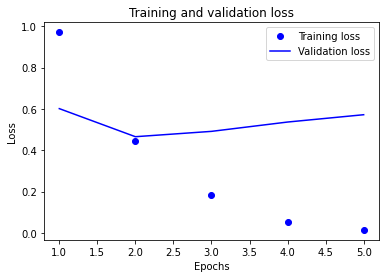

In [118]:
# Creating a plot of accuracy and loss over time
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc)+1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

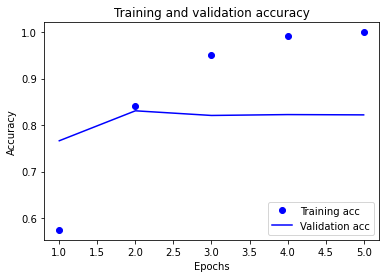

In [119]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [122]:
export_model = tf.keras.Sequential(
    [vectorize_layer, conv_model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(accuracy))

250/250 [==============================] - 3s 11ms/step - loss: 0.5946 - accuracy: 0.8073
Accuracy: 80.73%


In [123]:
# Inferencing on new data
def get_string_labels(predicted_scores_batch):
    predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
    predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
    return predicted_labels

inputs = [
    "var retValue    = ""; try { var crypto          = document.getElementById("");var resultVal       = MakeInput(form);var inputStr",  # javascript
    "What are the use cases of private constructor?",  # java
]
predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())

Question:  var retValue    = ; try { var crypto          = document.getElementById();var resultVal       = MakeInput(form);var inputStr
Predicted label:  b'javascript'
Question:  What are the use cases of private constructor?
Predicted label:  b'java'
